# Trends in Microbiome Talk Slides
    1. Overall information about the sequenced reads
    2. Phylum level information
    3. Known disease/cancer bacteria relationships
    Species, Genus, COG, TigrFam
        a. Largest outliers for 12-18-2014  
        b. Linear Trends
        c. Changepoints

In [1]:
import sys

# User Libraries
import tanner.stats.timeseries as ts
import tanner.stats.helpers as shelp
import tanner.analysis.microbiome as mb
import tanner.visual.timeseries as vts

# Python Libraries
import pandas as pd
import os 
import seaborn as sns

# Ipython Configuration
%pylab inline
%load_ext autoreload
%autoreload 2

# Data and analysis paths
microbiome_path = "/mounts/tscc/projects/Li-Fraumeni/data/family3/microbiome/14009b/aggregated/"
analysis_path = "/mounts/tscc/projects/Li-Fraumeni/analysis/microbiome/trends_in_microbiome_presentation"

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir $analysis_path

mkdir: cannot create directory ‘/mounts/tscc/projects/Li-Fraumeni/analysis/microbiome/trends_in_microbiome_presentation’: File exists


In [3]:
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

## Overall Trends

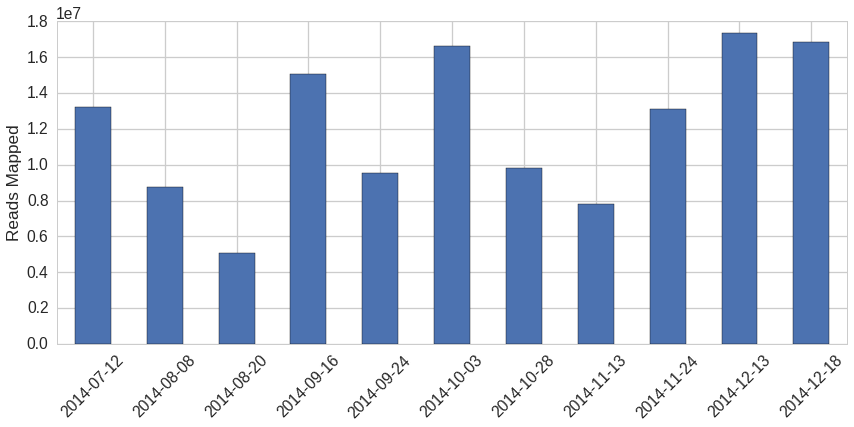

In [106]:
superkingdom_file = os.path.join(microbiome_path, 'superkingdom-reads-count.txt')
superkd_df = mb.load_aggregated(superkingdom_file)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax = superkd_df['Bacteria'].plot(kind='bar', stacked=True, ax=ax)
ticks = [ax.get_xticklabels()[i].get_text().split(' ')[0] for i in range(len(ax.get_xticklabels()))]
ax.set_xticklabels(ticks, rotation=45)
#legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
#          ncol=3, fancybox=True, shadow=True, frameon=True)
#legend.get_frame().set_facecolor('#FFFFFF')
ax.set_ylabel('Reads Mapped')
fig.tight_layout()
fig.savefig(os.path.join(analysis_path, 'reads_mapped.png'), dpi=300)

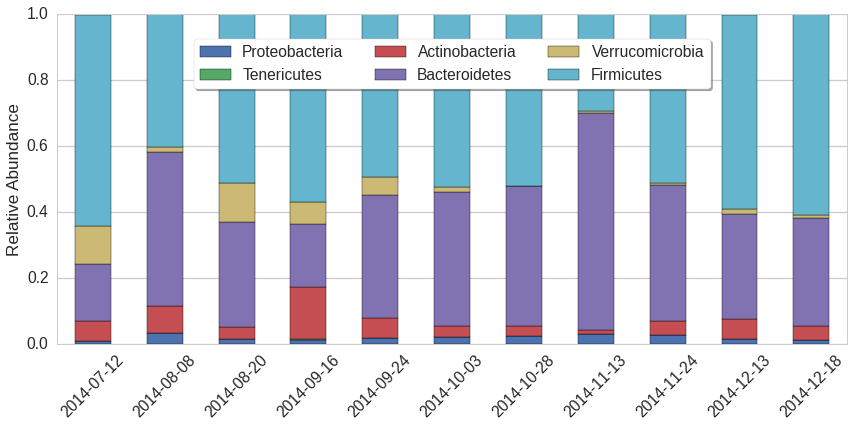

In [107]:
phylum_df = mb.load_aggregated(os.path.join(microbiome_path, 'Bacteria-phylum-abundance.txt'))
important_phyla = ['Proteobacteria', 'Tenericutes', 'Actinobacteria', 'Bacteroidetes', 'Verrucomicrobia', 'Firmicutes']
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax = phylum_df[important_phyla].plot(kind='bar', stacked=True, ax=ax)
ticks = [ax.get_xticklabels()[i].get_text().split(' ')[0] for i in range(len(ax.get_xticklabels()))]
ax.set_xticklabels(ticks, rotation=45)
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=3, fancybox=True, shadow=True, frameon=True)
legend.get_frame().set_facecolor('#FFFFFF')
ax.set_ylabel('Relative Abundance')
fig.tight_layout()
fig.savefig(os.path.join(analysis_path, 'abundance_phylum_level.png'), dpi=300)

In [108]:
species_df = mb.load_aggregated(os.path.join(microbiome_path, 'Bacteria-species-abundance.txt'))

### Cancer related microbiota

In [109]:
cancer_microbiomes = ['Helicobacter_pylori', 'Campylobacter_jejuni', 'Borellia_burgdorferi', 
                      'Chlamydia_psittaci', 'Salmonella_enterica']

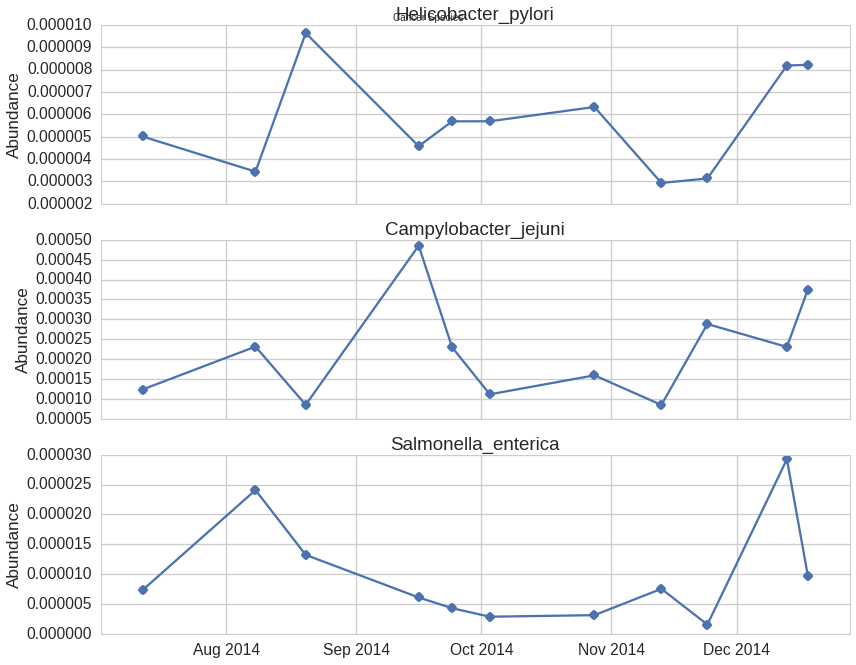

In [110]:
cancer_df = species_df[[x for x in cancer_microbiomes
                        if x in species_df.columns]]
cancer_df.columns = cancer_df.columns.droplevel([1, 2, 3, 4, 5])
fig = vts.default(cancer_df, main_title='Cancer Species')[0]
fig.tight_layout()
fig.savefig(os.path.join(analysis_path, 'cancer_bacteria.png'), dpi=300)

### Z-scores of time series for sample 2014-12-18 at genus level

In [111]:
genus_df = species_df.T.groupby(level=['phylum', 'class', 'order', 'family', 'genus']).agg(sum).T

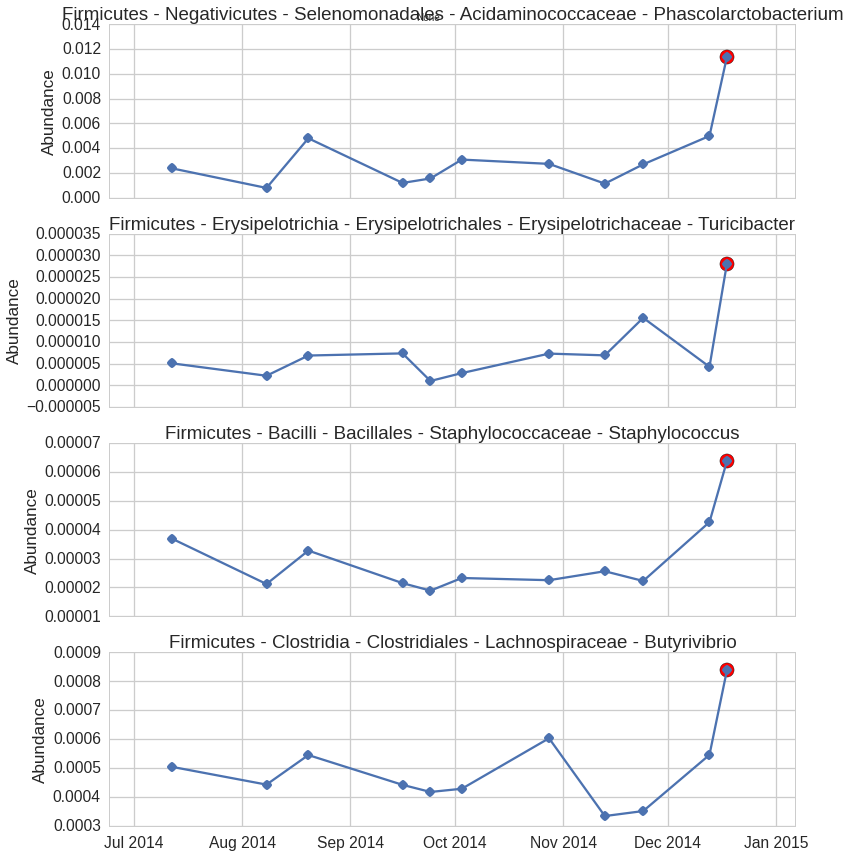

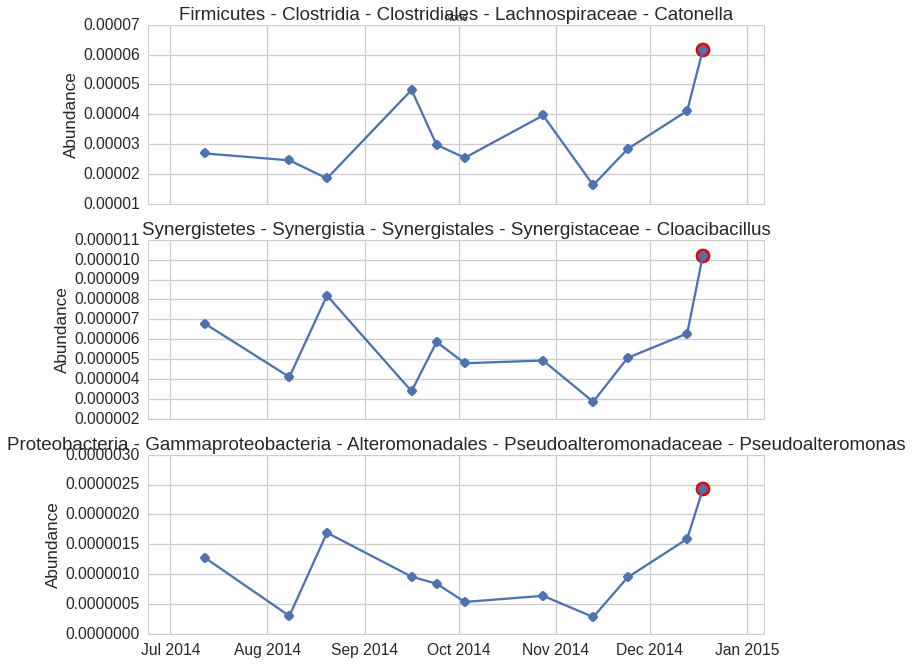

In [112]:
genus_df = genus_df[genus_df.columns[genus_df.mean() > 1e-06]]
genus_zscores = genus_df.apply(lambda x: ts.calculate_zscores(x, '2014-12-18', include_sample=True))
genus_zscores = genus_zscores.map(abs)
genus_zscores.sort(ascending=False)
genus_zscores = genus_zscores[genus_zscores > 2]
figs = vts.default(genus_df[genus_zscores.index], marksample='2014-12-18')
for i, fig in enumerate(figs):
    fig.tight_layout()
    fig.savefig(os.path.join(analysis_path, 'genus_2014-12-18_%d.png' % i), dpi=300)
    

In [113]:
species_df = species_df[species_df.columns[species_df.mean() > 1e-5]]
species_zscores = species_df.apply(lambda x: ts.calculate_zscores(x, '2014-12-18', include_sample=True))
species_zscores = species_zscores.map(abs)
species_zscores.sort(ascending=False)
species_zscores = species_zscores[species_zscores > 2]
species_zscores.head(5)

name                       family                 class       phylum      genus        order        
Clostridium_sp_CAG_354     Clostridiaceae         Clostridia  Firmicutes  Clostridium  Clostridiales    2.991971
Eubacterium_sp_CAG_76      Eubacteriaceae         Clostridia  Firmicutes  Eubacterium  Clostridiales    2.957674
_Clostridium_bifermentans  Peptostreptococcaceae  Clostridia  Firmicutes  NaN          Clostridiales    2.867022
_Clostridium_sordellii     Peptostreptococcaceae  Clostridia  Firmicutes  NaN          Clostridiales    2.852268
_Clostridium_hiranonis     Peptostreptococcaceae  Clostridia  Firmicutes  NaN          Clostridiales    2.784993
dtype: float64

#### All of them are just Clostridia

### Let's just do TigrFam, because these microbiota are unclear anyways.

In [114]:
fn = microbiome_path+'tigrfam-subrole-ann.txt'
tigr_df = mb.load_aggregated(fn)

In [115]:
outliers = ts.outliers(tigr_df, sample='2014-12-18', z_threshold=1.5, include_sample=True)

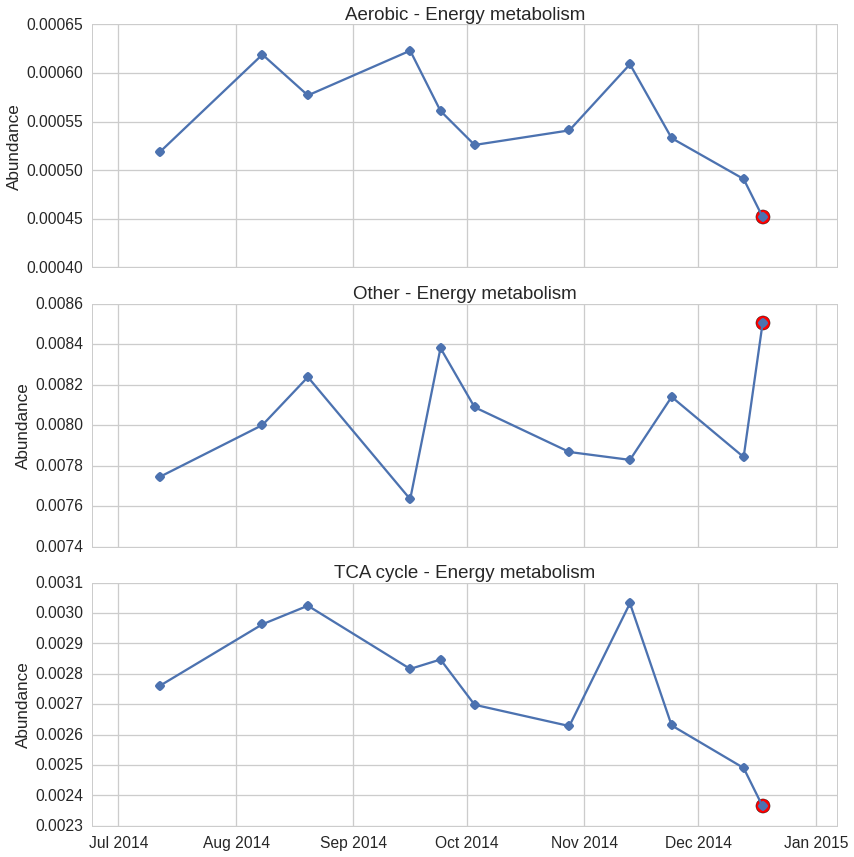

In [116]:
fig = vts.default(tigr_df[outliers['2014-12-18'][1:4]], main_title="", marksample='2014-12-18', samples_per_figure=3)[0]
fig.tight_layout()
fig.savefig(os.path.join(analysis_path, "tigr_fam_metabolism.png"))

### Linear Trend

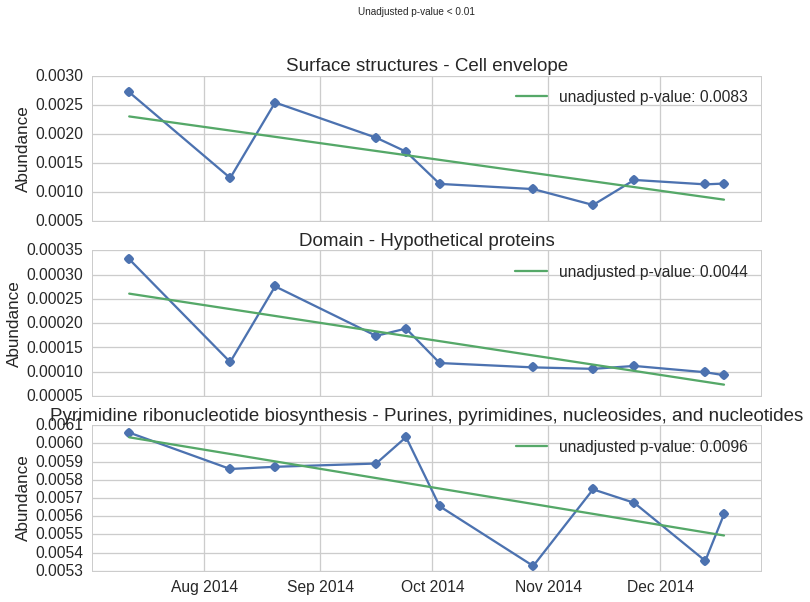

In [98]:
# Linear Regression:
pvalues = ts.regress(tigr_df)
file_prefix = os.path.join(analysis_path, 'lineartrend')
significant = pvalues[pvalues < 1e-02].index
vts.default(tigr_df[significant], 
                #fn_prefix = file_prefix,
                main_title='Unadjusted p-value < 0.01', 
                bestfit=True)

    


### Changepoint

In [99]:
# Changepoints:
file_prefix = os.path.join(analysis_path, 'changepoints')
changepoints = ts.changepoints(tigr_df, threshold=1.67)
changepoints = changepoints[changepoints > 0]
if len(changepoints) > 0:
    vts.default(tigr_df[changepoints.index], 
                fn_prefix = file_prefix,
                main_title = 'Changepoint', 
                changepoints = changepoints.values)

## COG